In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision
import os
import sys
import json
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class GoogLeNet(nn.Module):#总框架
    def __init__(self, num_classes=1000, aux_logits=False, init_weights=False):#分类个数，是否使用辅助分类器，是否对权重初始化
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits#传入辅助分类器

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)#下取整
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)#ceil_mode如果那是小数t上取整，f下取整
        # nn.LocalResponseNorm
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        # nn.LocalResponseNorm
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

#         if self.aux_logits:
#             self.aux1 = InceptionAux(512, num_classes)
#             self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))#自适应的平均池化，不限制输入图像尺寸
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:#权重初始化函数
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
#         if self.training and self.aux_logits:    # eval model lose this layer 测试模式下不用辅助训练器
#             aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
#         if self.training and self.aux_logits:    # eval model lose this layer
#             aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
#         if self.training and self.aux_logits:   # eval model lose this layer
#             return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [4]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):#输入特征矩阵深度，表格中对应的参数
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)#分支一

        self.branch2 = nn.Sequential( #分支二，两个卷积层用Seq函数顺序执行
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
            # 保证输出大小等于输入大小 output_size = (input_size - 3 + 2 * 1) / 1 + 1 = input_size
            #inception的每个分支输出的特征矩阵高宽必须相等。
        )

        self.branch3 = nn.Sequential(#分支三
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
            # 保证输出大小等于输入大小 output_size = (input_size - 5 + 2 * 2) / 1 + 1 = input_size
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )
    def forward(self, x):#前向传播，x为输入特征矩阵
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]#四个分支的输出
        return torch.cat(outputs, 1)#四个分支的输出合并,1对应tensor的channel，深度拼接

In [5]:
class InceptionAux(nn.Module):#辅助分类器
    def __init__(self, in_channels, num_classes):#输入深度，分类个数
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)#4*4*128
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):#正向传播
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)#输出展平，1对应tensor的channel
        x = F.dropout(x, 0.5, training=self.training)#0.5 舍弃50% training= 在训练模式下为ture 测试模式下为f
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

In [6]:
class BasicConv2d(nn.Module): #为了不用重复定义，定义一个基础的卷积和激活模板
    def __init__(self, in_channels, out_channels, **kwargs):#输入矩阵深度，输出矩阵深度
        super(BasicConv2d, self).__init__()
        #下面是两个层结构，卷积和激活层
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)
    #正向传播
    def forward(self, x):#x为特征矩阵
        x = self.conv(x)
        x = self.relu(x)
        return x

In [7]:
model = GoogLeNet()
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (branch2): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [8]:
transform = transforms.Compose(
        [transforms.Resize((96,96),2),#2插值
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024,
                                               shuffle=True, num_workers=0)
train_steps = len(train_loader)
print(train_steps)

D:\Develop\Anaconda3\envs\sdxx\lib\site-packages\torchvision\transforms\transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


49


In [9]:
val_set = torchvision.datasets.CIFAR10(root='./data', train=False,download=False, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1024,shuffle=False, num_workers=0)
val_num = len(val_set)
# val_data_iter = iter(val_loader)
# val_image, val_label = val_data_iter.next()

In [195]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [196]:
# import matplotlib.pyplot as plt
# import numpy as np
# def imshow(img):
#     img = img / 2 + 0.5
#     nping = img.numpy()
#     plt.imshow(np.transpose(nping, (1, 2, 0)))
#     plt.show()

cat   ship  ship  plane frog 


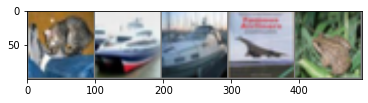

In [197]:
# print(' '.join(f'{classes[val_label[j]]:5s}' for j in range(5)))
# imshow(torchvision.utils.make_grid(val_image))

In [190]:
net = GoogLeNet(num_classes=10, aux_logits=False, init_weights=True)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003)

In [191]:
epochs = 5
best_acc = 0.0
save_path = './googleNet.pth'
for epoch in range(epochs):
    #训练
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
#         logits, aux_logits2, aux_logits1 = net(images.to(device))
#         loss0 = loss_function(logits, labels.to(device))
#         loss1 = loss_function(aux_logits1, labels.to(device))
#         loss2 = loss_function(aux_logits2, labels.to(device))
#         loss = loss0 + loss1 * 0.3 + loss2 * 0.3
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,epochs,loss)  
        
        #验证
        net.eval()
        acc = 0.0
        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))  # eval model only have last output layer
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %(epoch + 1, running_loss / train_steps, val_accurate))
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
print('Finished Training')

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:29<00:00,  1.13s/it]
[epoch 1] train_loss: 0.019  val_accuracy: 0.100
 62%|██████████████████████████████████████████████████▊                               | 49/79 [00:57<00:34,  1.13s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:31<00:00,  1.16s/it]
[epoch 1] train_loss: 0.036  val_accuracy: 0.103
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:31<00:00,  1.16s/it]
[epoch 1] train_loss: 0.041  val_accuracy: 0.095
 24%|███████████████████▋                                                              | 19/79 [00:21<01:07,  1.13s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:31<00:00,  1.15s/it]
[epoch 1] train_loss: 0.045  val_accuracy: 0.106
 89%|████████████████████████████████████████████████████████████████████████▋         | 70/79 [01:22<00:10,  1.13s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:32<00:00,  1.17s/it]
[epoch 1] train_loss: 0.047  val_accuracy: 0.100
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:32<00:00,  1.17s/it]
[epoch 1] train_loss: 0.049  val_accuracy: 0.103
train epoch[1/5] loss:2.507:   0%|▏                                                | 6/1389 [09:51<37:53:33, 98.64s/it]


KeyboardInterrupt: 

{'0': 'plane', '1': 'car', '2': 'bird', '3': 'cat', '4': 'deer', '5': 'dog', '6': 'frog', '7': 'horse', '8': 'ship', '9': 'truck'}
class: plane        prob: 0.0122
class: car          prob: 0.00173
class: bird         prob: 0.0405
class: cat          prob: 0.000282
class: deer         prob: 0.0457
class: dog          prob: 0.000179
class: frog         prob: 0.894
class: horse        prob: 0.00259
class: ship         prob: 0.000219
class: truck        prob: 0.00224


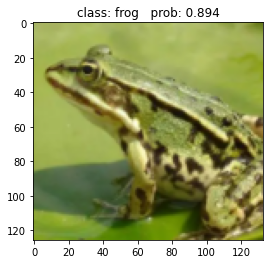

In [10]:
    #预测
    data_transform = transforms.Compose(
        [transforms.Resize((96,96),2),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # load image
    img_path = "./f1.png"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    # img = Image.open(img).convert('RGB')
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)
    print(class_indict)
    # create model
    model = GoogLeNet(num_classes=10, aux_logits=False).to(device)

    # load model weights
    weights_path = "./googleNetG.pth"
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    missing_keys, unexpected_keys = model.load_state_dict(torch.load(weights_path, map_location=device),
                                                        strict=False)

    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()